### First experiments with U-Net on CESM sat data

Trained model with **variable mask** and **augmentation factor 3** on samples with rel. amount of missing values in the **range of [0,1]**.

Use this single model to find the **optimized sampling strategy** in a brute-force manner.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'surface-air-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sat' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_0_100'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_1'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sat_CESM_variable_range_0_100_factor_3_final/relevance_1

number of samples:  240
patch size:  1
max. number of patches to include:  50
max. acc. rel. loss as threshold:  0.9


In [15]:
# ## For the following individual list of samples:

# relevance_3_samples = [
#     0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,
#     40,41,42,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,9530,9531,9532,9533,9534,9535,9536,9537,9538,9539,
#     9540,9541,9542,9543,9544,9545,9546,9548,9549,9550,9551,9553,9554,9555,9556,9557,9558,9559,9560,9561,9562,
#     9563,9564,9565,9566,9567,9568,9569,9570,9571,9572,9573,9574,9575,9576,9577,9578,9579,9580,9581,9582,9583,
#     9584,9585,9586,9587,9588,9589
# ]

# # Combine results:
# for n in relevance_3_samples:

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in relevance_3_samples:  

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:   

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (113, 96, 144)
patch_orders: (113, 13824)
rel_loss_reductions: (113, 13824)
abs_loss_reductions: (113, 13824)
acc_rel_loss_reductions: (113, 13824)


In [4]:
# ## For complete list of samples:

# start_at = 0
# end_at = start_at + n_samples

# # Combine results:
# for n in np.arange(start_at,end_at): 

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):   

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (120, 96, 144)
patch_orders: (120, 13824)
rel_loss_reductions: (120, 13824)
abs_loss_reductions: (120, 13824)
acc_rel_loss_reductions: (120, 13824)


In [5]:
# start_at = 9470
# end_at = 9470+120

# # Reload results for this experiment:
# rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
# patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
# abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
# rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
# acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders_new.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (240, 96, 144)
patch_orders: (240, 13824)
rel_loss_reductions: (240, 13824)
abs_loss_reductions: (240, 13824)
acc_rel_loss_reductions: (240, 13824)


In [6]:
# # Get path to model:
# path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
#                       +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

# # Reload final model, trained on range:
# model = tf.keras.models.load_model(path_to_model / 'missing_0_100' / 'model')

2023-03-08 05:08:16.456441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-03-08 05:08:16.456463: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 05:08:16.456476: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl211): /proc/driver/nvidia/version does not exist
2023-03-08 05:08:16.461472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
## Prepare validation samples:

# Path to full data:
# path_to_data = 'climate_index_collection/data/raw/2022-08-22/'
path_to_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load data:
data_raw = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data_raw)

# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(data.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
train_input, val_input, _, _, train_min, train_max, _, _ = split_and_scale_data(
    data, 
    missing_mask_1,
    train_val_split, 
    scale_to
)

In [7]:
# Get possible number of patches in lat and lon directions, respectively:
n_lat = int(val_input[0:1].shape[1] / patch_size)
n_lon = int(val_input[0:1].shape[2] / patch_size)

# Obtain total number of patches:
n_patches = int(n_lat * n_lon)

# If max. number of patches to include is given as -1, set to total number of possible patches:
if max_patch_num == -1:
    max_patch_num = n_patches

In [8]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# Check dimensions:
print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (240, 96, 144)
patch_orders: (240, 13824)
rel_loss_reductions: (240, 13824)
abs_loss_reductions: (240, 13824)
acc_rel_loss_reductions: (240, 13824)


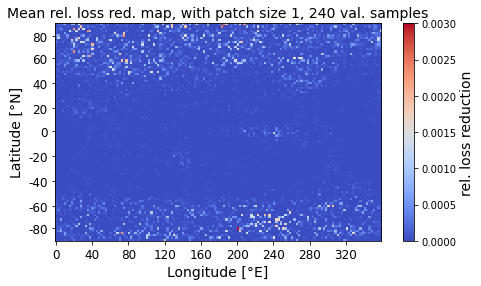

In [9]:
## range_0_100, relevance_1: TRAINING samples!
# Include 240 samples, 120 from both edges of the time line.
# patch_size = 1
# max_patch_num = 50
# max_acc_rel_loss_reduction = 0.9

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

/tmp/ipykernel_3100738/3221499229.py:2: RuntimeWarning: Mean of empty slice
  mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)


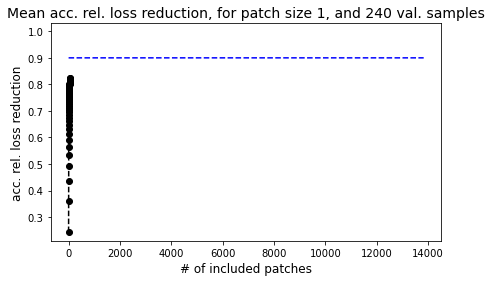

In [10]:
# Compute mean acc. rel. loss reduction, over desired number of considered validation samples:
mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)

# Plot mean acc. rel. loss reduction over desired number of patches to include:
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,n_patches,step=1)+1, mean_acc_rel_loss_reduction[:n_patches], color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,n_patches,step=1)+1, np.ones(n_patches)*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('Mean acc. rel. loss reduction, for patch size '+str(patch_size)+', and '+str(n_samples)+' val. samples', fontsize=14)
axes.set_xlabel('# of included patches', fontsize=12)
axes.set_ylabel('acc. rel. loss reduction', fontsize=12)
#axes.legend()
plt.show() 

### Clustering with GMM to find optimal masks

#### 99.9% missing

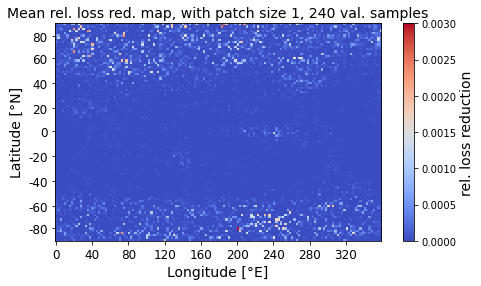

In [11]:
## range_0_100, relevance_1: TRAINING samples!
# Include first 120 samples, hence from the beginning of training data.
# patch_size = 1
# max_patch_num = 50
# max_acc_rel_loss_reduction = 0.9

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [12]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

non-zero entries in mean rel. loss reduction map:  6854


In [36]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.001

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  206


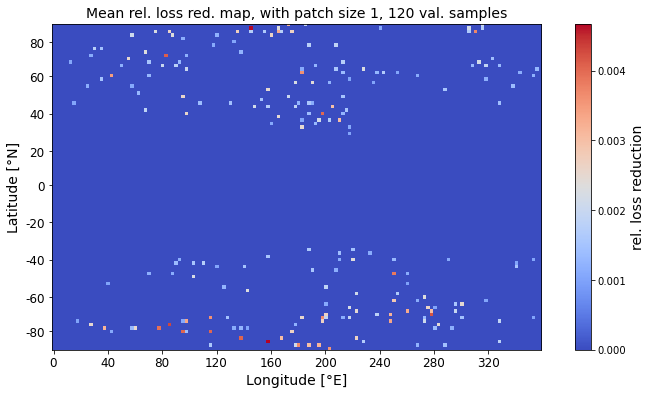

In [37]:
## Plot mean rel. loss reduction map, only grid points with value exceeding threshold, used to cut-off noise:
mean_rel_loss_reduction_map_cut = (mean_rel_loss_reduction_map>noise_threshold) * mean_rel_loss_reduction_map

# Plot resulting mean rel. loss reduction map with cut off noise as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map_cut,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [41]:
# Get clusters from GMM algorithms with pre-specified number of clusters = 14 (=0.1% for CESM slp grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_999 = GaussianMixture(n_components=14, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_999_clusters = GMM_999.predict(xyz[:,:2])

## Prepare colors for visualizing clusters:

# # Set colors:
# colors = ['red', 'orange', 'yellow', 'blue', 'pink', 'cyan', 'magenta', 'grey', 'brown', 'purple']

# # Create list of colors:
# GMM_colors = []
# for i in range(len(GMM_999_clusters)):
#     GMM_colors.append(colors[GMM_999_clusters[i]])

In [56]:
## Convert obtained cluster means to CESM lat/lon grid:

# Initialize storage:
cluster_means_999_GMM = np.zeros(GMM_999.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_999_GMM[:,0] = np.round(GMM_999.means_[:,0]*(n_lon-1),0).astype(int)
cluster_means_999_GMM[:,1] = np.round(GMM_999.means_[:,1]*(n_lat-1),0).astype(int)

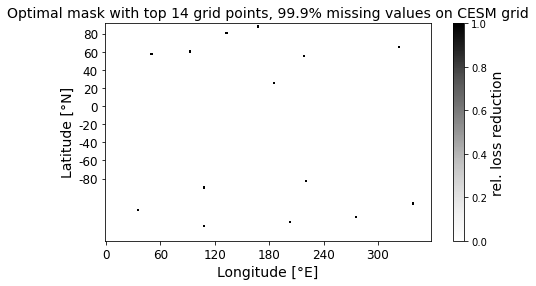

In [59]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_GMM = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_means_999_GMM:
    
    # Set grid points to True:
    mask_999_GMM[xyz[1],xyz[0]]=True

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_GMM,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 14 grid points, 99.9% missing values on CESM grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [58]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_range_0_100_factor_3_final/relevance_1


In [60]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_999.npy", mask_999_GMM)

#### 99% missing

non-zero entries in mean rel. loss reduction map:  3646
noise threshold: 0.0005
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  446


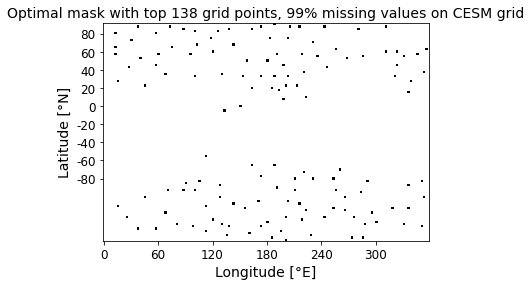

In [63]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.0005

print('noise threshold:',noise_threshold)

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 138 (=1% for CESM slp grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_99 = GaussianMixture(n_components=138, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_99_clusters = GMM_99.predict(xyz[:,:2])

## Convert obtained cluster means to CESM lat/lon grid:

# Initialize storage:
cluster_means_99_GMM = np.zeros(GMM_99.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_99_GMM[:,0] = np.round(GMM_99.means_[:,0]*(n_lon-1),0).astype(int)
cluster_means_99_GMM[:,1] = np.round(GMM_99.means_[:,1]*(n_lat-1),0).astype(int)

## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_GMM = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_means_99_GMM:
    
    # Set grid points to True:
    mask_99_GMM[xyz[1],xyz[0]]=True

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99_GMM,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 138 grid points, 99% missing values on CESM grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [65]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_range_0_100_factor_3_final/relevance_1


In [66]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_99.npy", mask_99_GMM)

#### 95% missing

non-zero entries in mean rel. loss reduction map:  3646
noise threshold: 0.0
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  3646


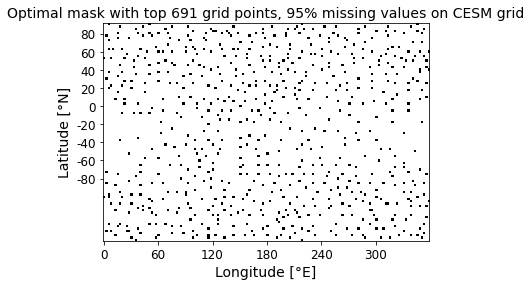

In [70]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.0

print('noise threshold:',noise_threshold)

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 691 (=5% for CESM slp grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_95 = GaussianMixture(n_components=691, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_95_clusters = GMM_95.predict(xyz[:,:2])

## Convert obtained cluster means to CESM lat/lon grid:

# Initialize storage:
cluster_means_95_GMM = np.zeros(GMM_95.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_95_GMM[:,0] = np.round(GMM_95.means_[:,0]*(n_lon-1),0).astype(int)
cluster_means_95_GMM[:,1] = np.round(GMM_95.means_[:,1]*(n_lat-1),0).astype(int)

## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_GMM = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_means_95_GMM:
    
    # Set grid points to True:
    mask_95_GMM[xyz[1],xyz[0]]=True

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95_GMM,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 691 grid points, 95% missing values on CESM grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [71]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_range_0_100_factor_3_final/relevance_1


In [72]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95.npy", mask_95_GMM)

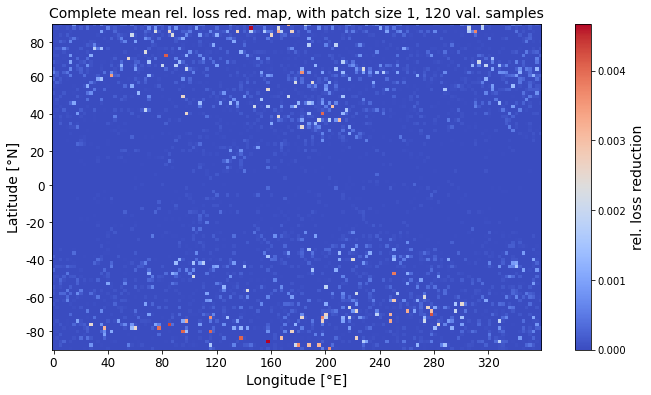

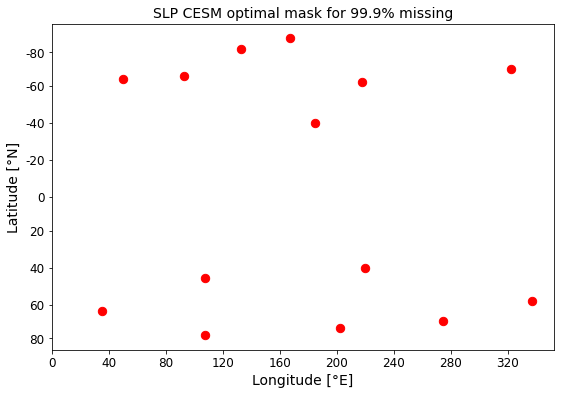

In [43]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Complete mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# # Plot resulting mean rel. loss reduction map with cut off noise as heatmap:        
# fig, ax = plt.subplots(figsize=(12, 6))
# im = plt.imshow(np.flip(mean_rel_loss_reduction_map_cut,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
# cbar = plt.colorbar(im)
# cbar.set_label('rel. loss reduction', fontsize=14)
# plt.title('Cut off mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
# plt.xlabel('Longitude [°E]', fontsize=14)
# plt.ylabel('Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
# plt.show()

# Show obtained rescaled positions with non-zero mean rel. loss reduction and the corresponding clusters as scatter plot:
fig, ax = plt.subplots(figsize=(9,6))
# plt.scatter(lon_rescaled, lat_rescaled, s=3, c=GMM_colors, cmap='coolwarm', vmin=0.0, vmax=0.002)
plt.scatter(cluster_means_lon_grid_rescaled, cluster_means_lat_grid_rescaled, s=70, c='red')
plt.title('SLP CESM optimal mask for 99.9% missing', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [ ]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_kmeans = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xy_pos in cluster_centers_999:
    
    # Set grid points to True:
    mask_999_kmeans[xy_pos[1],xy_pos[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_kmeans,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

### Try clustering or fitting 2D Gaussians to mean rel. loss map

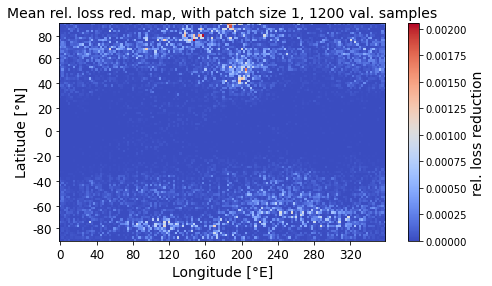

In [274]:
## relevance_1: TRAINING samples!
# Include ALL 1,200 samples, 600 from both edges of the time line.
# patch_size = 1
# max_patch_num = 14
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

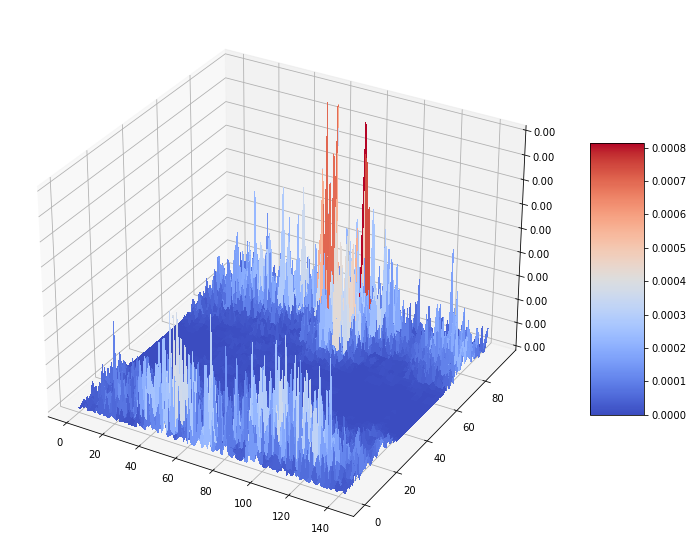

In [160]:
## Plot mean rel. loss map as 3D surface

fig, ax = plt.subplots(figsize=(14,10), subplot_kw={"projection": "3d"})
X = np.arange(0,144, step=1)
Y = np.arange(0,96, step=1)
X, Y = np.meshgrid(X, Y)
Z = mean_rel_loss_reduction_map

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [178]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map==0))

non-zero entries in mean rel. loss reduction map:  5933


In [290]:
## Start with 2D clustering of x/y positions for non-zero entries:

# Create tuples of x/y positions:
xy_pos = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.000:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xy-tuple, scaled to [0,1] in either dimension:
            xy_pos.append([(x+1)/n_lon, (y+1)/n_lat])

# Convert list of xy-positions to np.array:
xy_pos = np.array(xy_pos)

# Output number of obtained tuples:
print("number of xy-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xy_pos))

number of xy-tuples representing non-zero entries in mean rel. loss reduction map:  7891


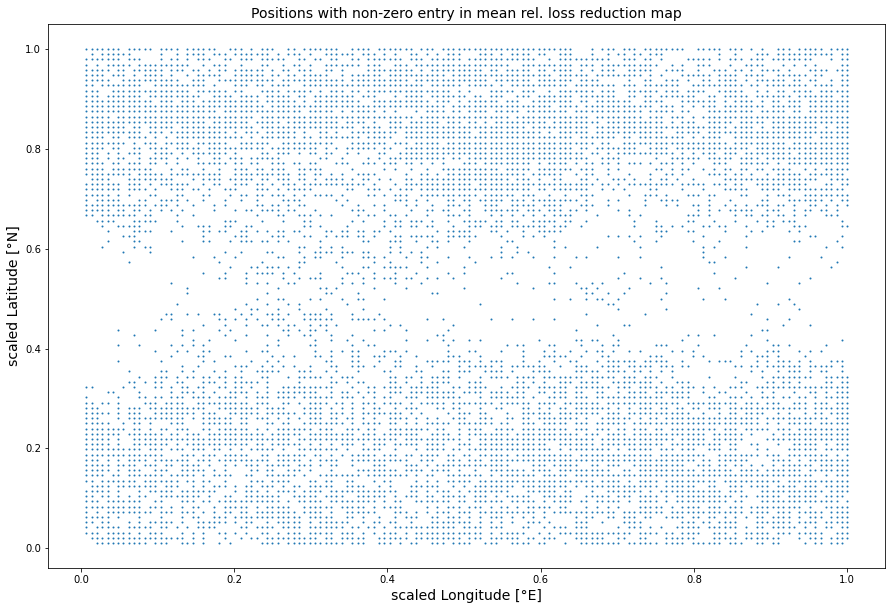

In [293]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(xy_pos[:,0], xy_pos[:,1], s=1)
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

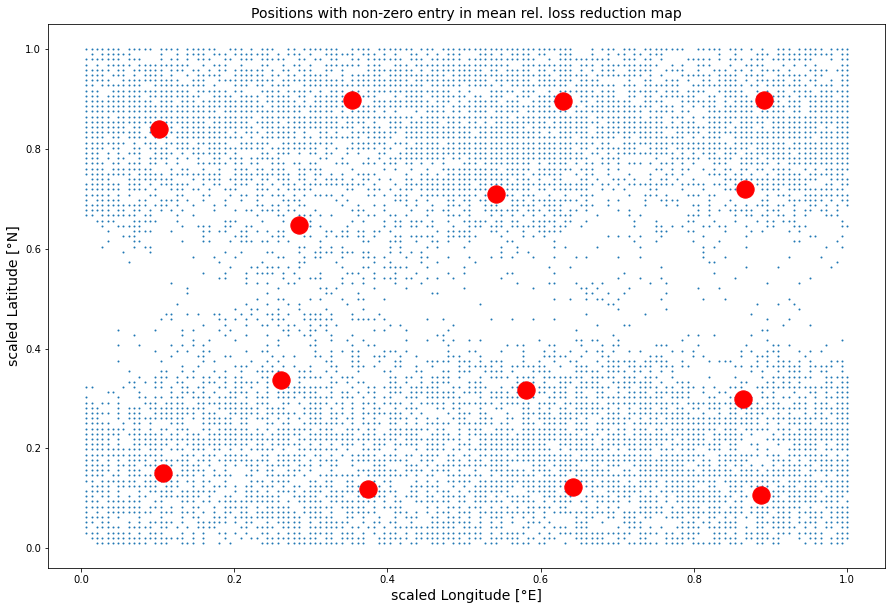

In [294]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 14 (=0.1%):
kmeans_999 = KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_999.fit_predict(xy_pos)

# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(xy_pos[:,0], xy_pos[:,1], s=1)
plt.scatter(kmeans_999.cluster_centers_[:, 0], kmeans_999.cluster_centers_[:, 1], s=300, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()


In [308]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_999 = np.zeros(kmeans_999.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_centers_999[:,0] = np.round(kmeans_999.cluster_centers_[:,0]*n_lon,0).astype(int)
cluster_centers_999[:,1] = np.round(kmeans_999.cluster_centers_[:,1]*n_lat,0).astype(int)

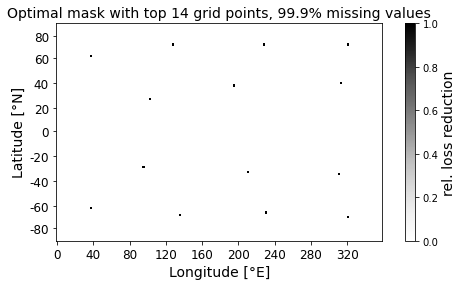

In [310]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_kmeans = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xy_pos in cluster_centers_999:
    
    # Set grid points to True:
    mask_999_kmeans[xy_pos[1],xy_pos[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_kmeans,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [311]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_1


In [312]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_999_kmeans.npy", mask_999_kmeans)

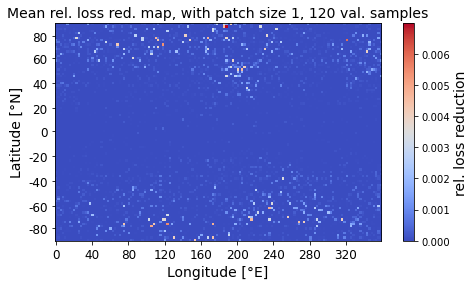

In [318]:
## relevance_2: TRAINING samples!
# Include ALL 120 samples, 60 from both edges of the time line.
# patch_size = 1
# max_patch_num = 138
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [319]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map==0))

non-zero entries in mean rel. loss reduction map:  5213


In [320]:
## Start with 2D clustering of x/y positions for non-zero entries:

# Create tuples of x/y positions:
xy_pos = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.000:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xy-tuple, scaled to [0,1] in either dimension:
            xy_pos.append([(x+1)/n_lon, (y+1)/n_lat])

# Convert list of xy-positions to np.array:
xy_pos = np.array(xy_pos)

# Output number of obtained tuples:
print("number of xy-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xy_pos))

number of xy-tuples representing non-zero entries in mean rel. loss reduction map:  8611


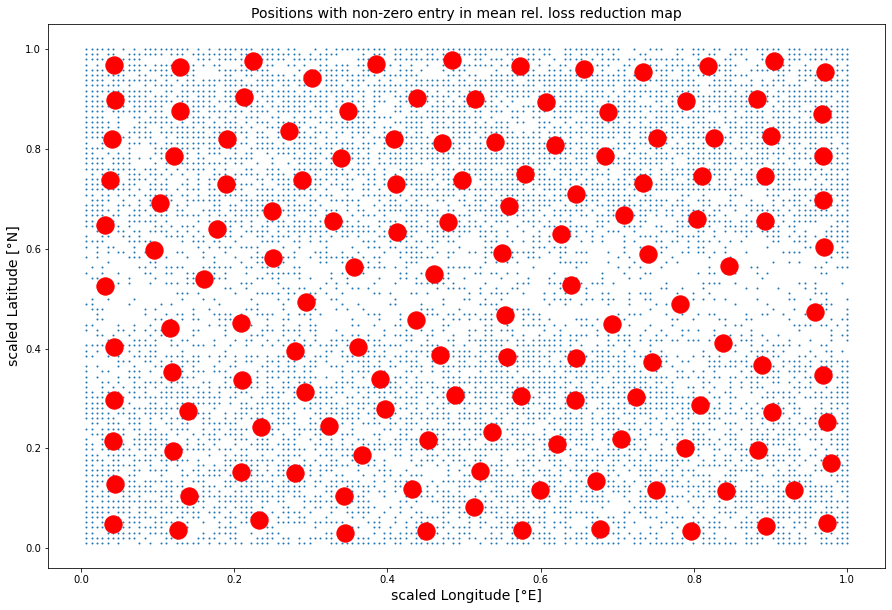

In [321]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 138 (=1%):
kmeans_99 = KMeans(n_clusters=138, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_99.fit_predict(xy_pos)

# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(xy_pos[:,0], xy_pos[:,1], s=1)
plt.scatter(kmeans_99.cluster_centers_[:, 0], kmeans_99.cluster_centers_[:, 1], s=300, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [322]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_99 = np.zeros(kmeans_99.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_centers_99[:,0] = np.round(kmeans_99.cluster_centers_[:,0]*n_lon,0).astype(int)
cluster_centers_99[:,1] = np.round(kmeans_99.cluster_centers_[:,1]*n_lat,0).astype(int)

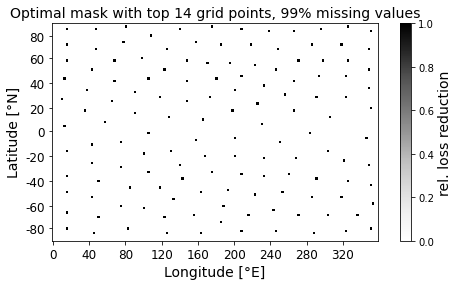

In [323]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_kmeans = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xy_pos in cluster_centers_99:
    
    # Set grid points to True:
    mask_99_kmeans[xy_pos[1],xy_pos[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99_kmeans,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [324]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_2


In [325]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_99_kmeans.npy", mask_99_kmeans)

### Extend Kmeans clustering to 3D: Take actual rel. loss reduction into account, not only x-y-position of grid points

In [10]:
### Now have a mean acc. rel. loss map for patch size 1, hence on grip point scale.
### With a total number of (n_lat x n_lon) 96 x 144 = 13,824 grid points, we define fixed masks from the most relevant XX grid points.

# 14 grid points --> 99.9% missing values
n_gridpoints_999 = int(np.round(0.001*n_lat*n_lon,0))
# 138 grid points --> 99% missing values
n_gridpoints_99 = int(np.round(0.01*n_lat*n_lon,0))
# 691 grid points --> 95% missing values
n_gridpoints_95 = int(np.round(0.05*n_lat*n_lon,0))

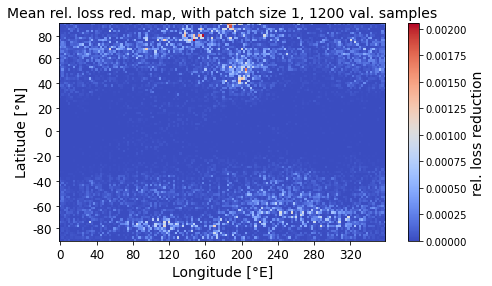

In [58]:
## relevance_1: TRAINING samples!
# Include ALL 1,200 samples, 600 from both edges of the time line.
# patch_size = 1
# max_patch_num = 14
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [12]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map==0))

non-zero entries in mean rel. loss reduction map:  8362


In [13]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.0:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  5462


In [14]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 14 (=0.1%):
kmeans_999_3D = KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_999_3D.fit_predict(xyz)

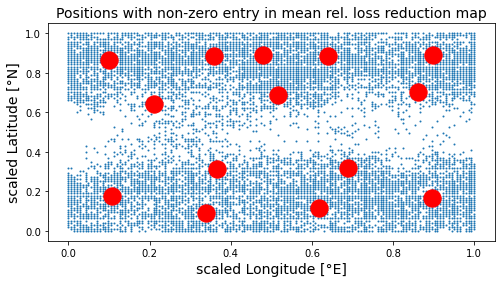

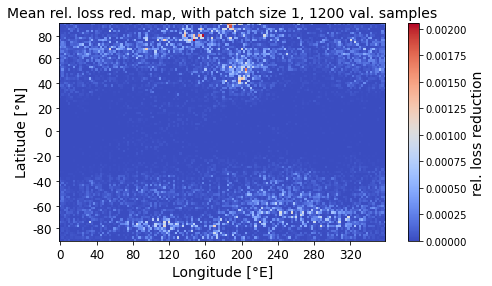

In [15]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(xyz[:,0], xyz[:,1], s=1)
plt.scatter(kmeans_999_3D.cluster_centers_[:, 0], kmeans_999_3D.cluster_centers_[:, 1], s=300, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [16]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_999_3D = np.zeros(kmeans_999_3D.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_centers_999_3D[:,0] = np.round(kmeans_999_3D.cluster_centers_[:,0]*(n_lon-1),0).astype(int)
cluster_centers_999_3D[:,1] = np.round(kmeans_999_3D.cluster_centers_[:,1]*(n_lat-1),0).astype(int)

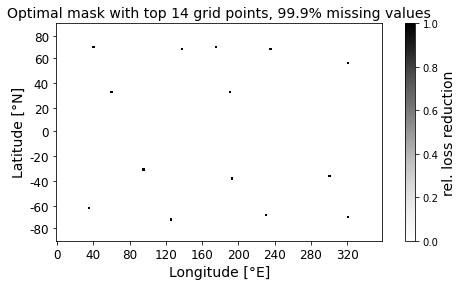

In [17]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_kmeans_3D = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_centers_999_3D:
    
    # Set grid points to True:
    mask_999_kmeans_3D[xyz[1],xyz[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_kmeans_3D,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [18]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_1


In [19]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_999_kmeans_3D_600_samples.npy", mask_999_kmeans_3D)

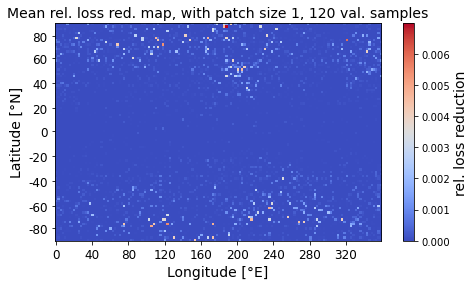

In [27]:
## relevance_2: TRAINING samples!
# Include ALL 120 samples, 60 from both edges of the time line.
# patch_size = 1
# max_patch_num = 138
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [28]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map==0))

non-zero entries in mean rel. loss reduction map:  5213


In [29]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.0:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  8611


In [30]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 138 (=1%):
kmeans_99_3D = KMeans(n_clusters=138, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_99_3D.fit_predict(xyz)

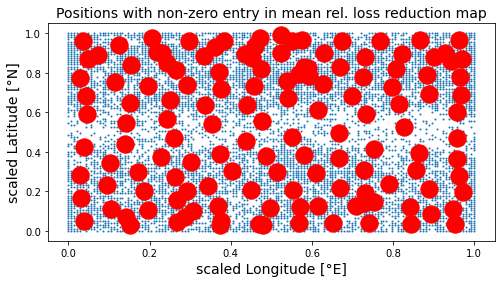

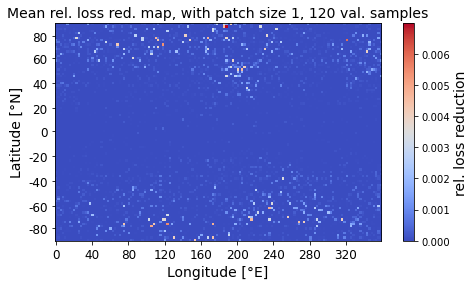

In [31]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(xyz[:,0], xyz[:,1], s=1)
plt.scatter(kmeans_99_3D.cluster_centers_[:, 0], kmeans_99_3D.cluster_centers_[:, 1], s=300, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [32]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_99_3D = np.zeros(kmeans_99_3D.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_centers_99_3D[:,0] = np.round(kmeans_99_3D.cluster_centers_[:,0]*(n_lon-1),0).astype(int)
cluster_centers_99_3D[:,1] = np.round(kmeans_99_3D.cluster_centers_[:,1]*(n_lat-1),0).astype(int)

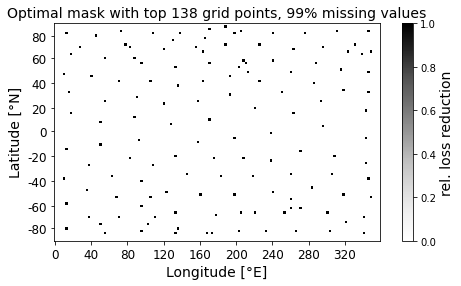

In [33]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_kmeans_3D = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_centers_99_3D:
    
    # Set grid points to True:
    mask_99_kmeans_3D[xyz[1],xyz[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99_kmeans_3D,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [34]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_2


In [35]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_99_kmeans_3D.npy", mask_99_kmeans_3D)

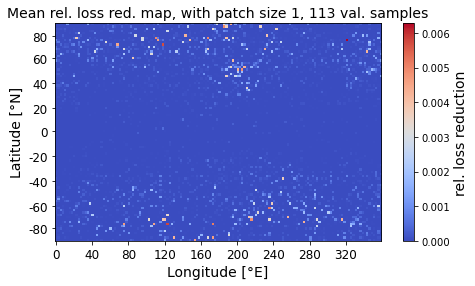

In [41]:
## relevance_3: TRAINING samples!
# Include ALL 113 samples, from both edges of the time line. Intended to include 120, but some batches crashed, due to memory issues.
# patch_size = 1
# max_patch_num = 691
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [42]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map==0))

non-zero entries in mean rel. loss reduction map:  5304


In [43]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.0:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  8520


In [44]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 138 (=1%):
kmeans_95_3D = KMeans(n_clusters=691, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_95_3D.fit_predict(xyz)

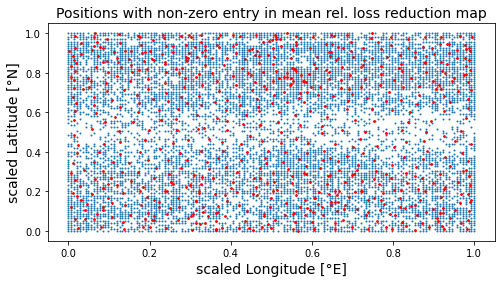

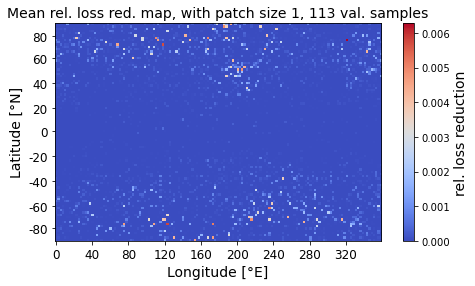

In [45]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(xyz[:,0], xyz[:,1], s=1)
plt.scatter(kmeans_95_3D.cluster_centers_[:, 0], kmeans_95_3D.cluster_centers_[:, 1], s=3, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting FLIPPED mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [46]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_95_3D = np.zeros(kmeans_95_3D.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_centers_95_3D[:,0] = np.round(kmeans_95_3D.cluster_centers_[:,0]*(n_lon-1),0).astype(int)
cluster_centers_95_3D[:,1] = np.round(kmeans_95_3D.cluster_centers_[:,1]*(n_lat-1),0).astype(int)

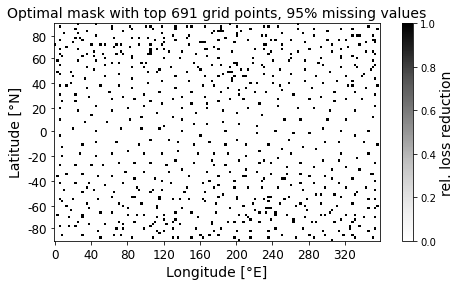

In [47]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_kmeans_3D = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_centers_95_3D:
    
    # Set grid points to True:
    mask_95_kmeans_3D[xyz[1],xyz[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95_kmeans_3D,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [48]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_3


In [49]:
## Store masks, to re-use in batch:
np.save(path_to_store_masks / "optimal_sampling_mask_95_kmeans_3D.npy", mask_95_kmeans_3D)

In [24]:
### Now have a mean acc. rel. loss map for patch size 1, hence on grip point scale, averaged over the first 120 validation samples.
### With a total number of (n_lat x n_lon) 96 x 144 = 13,824 grid points, we define fixed masks from the most relevant XX grid points.

# 14 grid points --> 99.9% missing values
n_gridpoints_999 = int(np.round(0.001*n_lat*n_lon,0))
# 138 grid points --> 99% missing values
n_gridpoints_99 = int(np.round(0.01*n_lat*n_lon,0))
# 691 grid points --> 95% missing values
n_gridpoints_95 = int(np.round(0.05*n_lat*n_lon,0))

In [25]:
# Start with mean rel. loss reduction map. Reshape to one-dimensional array:
mean_rel_loss_reduction_map_flat = mean_rel_loss_reduction_map.reshape((n_lat*n_lon))

# Using argsort yields mean acc. rel. in ascending order.
# Use the final XX grid points, containing the highest rel. loss reduction.
top_n_gridpoints_999 = np.argsort(mean_rel_loss_reduction_map_flat)[-n_gridpoints_999:]
top_n_gridpoints_99 = np.argsort(mean_rel_loss_reduction_map_flat)[-n_gridpoints_99:]
top_n_gridpoints_95 = np.argsort(mean_rel_loss_reduction_map_flat)[-n_gridpoints_95:]

# Initialize one-dimensional boolean mask of FALSE, dimension (n_lat x n_lon):
mask_999_flat = (np.zeros((n_lat*n_lon))!=0)
mask_99_flat = (np.zeros((n_lat*n_lon))!=0)
mask_95_flat = (np.zeros((n_lat*n_lon))!=0)

# Set top n grid points to True:
mask_999_flat[top_n_gridpoints_999] = True
mask_99_flat[top_n_gridpoints_99] = True
mask_95_flat[top_n_gridpoints_95] = True

# Reshape mask to two-dimensional boolean mask:
mask_999 = mask_999_flat.reshape((n_lat, n_lon))
mask_99 = mask_99_flat.reshape((n_lat, n_lon))
mask_95 = mask_95_flat.reshape((n_lat, n_lon))

In [103]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_2


In [105]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_999.npy", mask_999)
# np.save(path_to_store_masks / "optimal_sampling_mask_99.npy", mask_99)
# np.save(path_to_store_masks / "optimal_sampling_mask_95.npy", mask_95)

In [13]:
path_to_slp_CESM_999_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_1')
path_to_slp_CESM_99_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_2')
path_to_slp_CESM_95_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_3')

## Reload masks:
mask_999 = np.load(path_to_slp_CESM_999_mask / "optimal_sampling_mask_999.npy")
mask_99 = np.load(path_to_slp_CESM_99_mask / "optimal_sampling_mask_99.npy")
mask_95 = np.load(path_to_slp_CESM_95_mask / "optimal_sampling_mask_95.npy")


In [131]:
# First and last 180 training samples, each (relevance_1):
top_n_gridpoints_999

array([ 1264, 12127, 12731, 12800, 13755, 10880,  1554,  1337,   213,
       10882,   196, 13050, 13015, 13611])

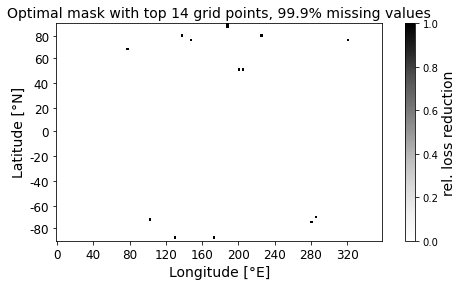

In [32]:
## Plot fixed masks as heatmap (relevance_1):        
# First and last 180 training samples, each:

# missing 99.9%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

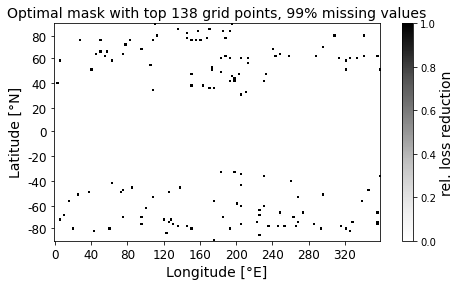

In [12]:
## Plot fixed masks as heatmap (relevance_exp_13):        
# First 36 validation samples:

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

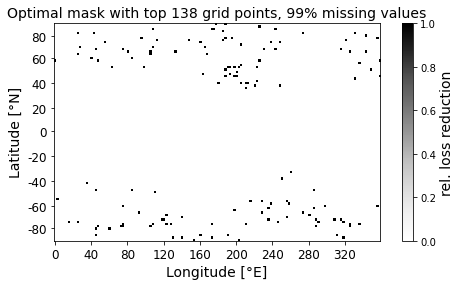

In [44]:
## Plot fixed masks as heatmap (relevance_2):        
# First and last 30 training samples, each:

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

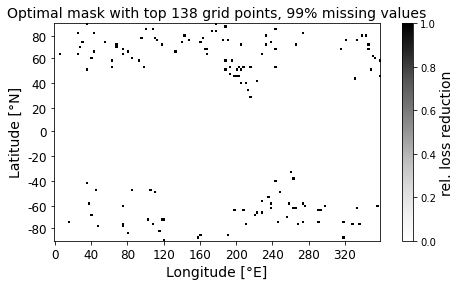

In [104]:
## Plot fixed masks as heatmap (relevance_2):        
# Last 60 training samples:

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

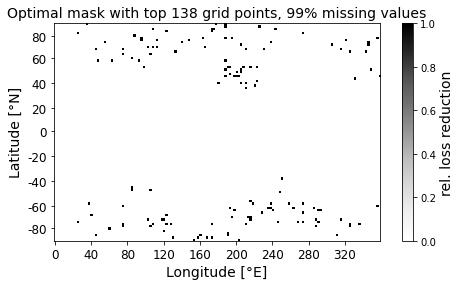

In [66]:
## Plot fixed masks as heatmap (relevance_2):        
# First and last 45 training samples, each:

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

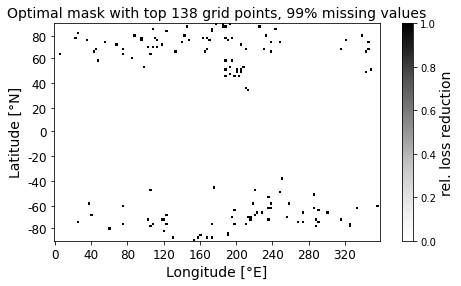

In [33]:
## Plot fixed masks as heatmap (relevance_2):        
# First and last 60 training samples, each:

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

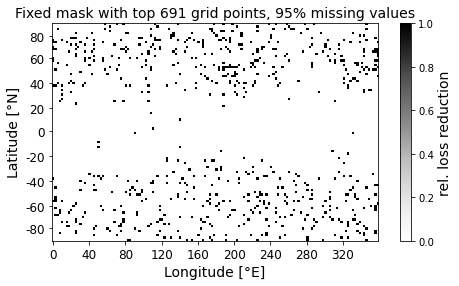

In [54]:
## Plot fixed masks as heatmap (relevance_3):        
# First and last 30 training samples, each:

# missing 95%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Fixed mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

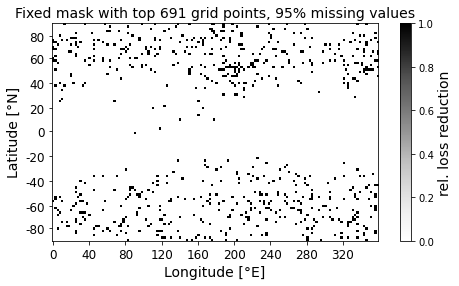

In [76]:
## Plot fixed masks as heatmap (relevance_3):        
# First and last 45 training samples, each:

# missing 95%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Fixed mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

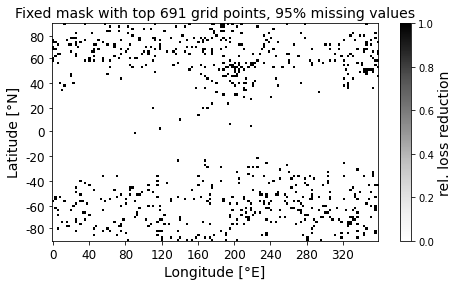

In [34]:
## Plot fixed masks as heatmap (relevance_3):        
# First and last 60 training samples, each:

# missing 95%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Fixed mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

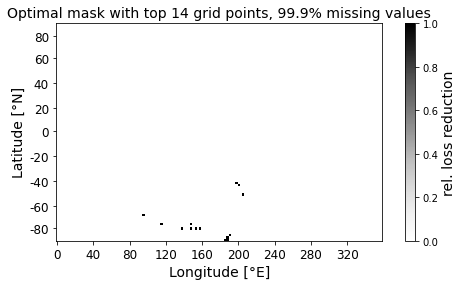

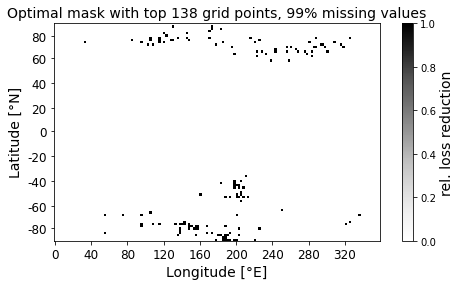

In [18]:
## Plot fixed masks as heatmap:        

# missing 99.9%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_999, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_99, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# # missing 95%
# fig, ax = plt.subplots(figsize=(8, 4))
# im = plt.imshow(mask_95, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
# cbar = plt.colorbar(im)
# cbar.set_label('rel. loss reduction', fontsize=14)
# plt.title('Fixed mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
# plt.xlabel('Longitude [°E]', fontsize=14)
# plt.ylabel('Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
# plt.show()

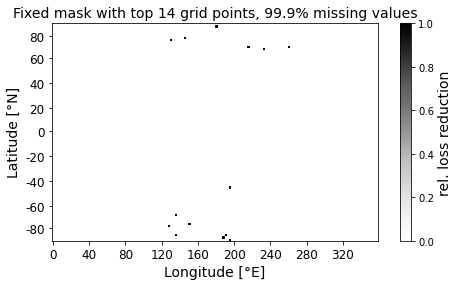

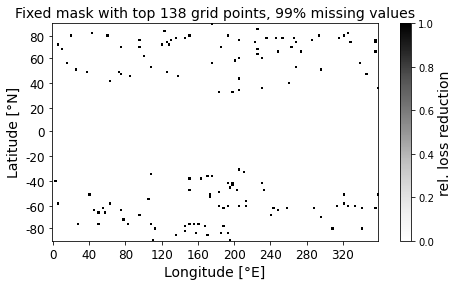

In [34]:
## Plot fixed masks as heatmap:        

# missing 99.9%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_999, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# missing 99%
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_99, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# # missing 95%
# fig, ax = plt.subplots(figsize=(8, 4))
# im = plt.imshow(mask_95, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
# cbar = plt.colorbar(im)
# cbar.set_label('rel. loss reduction', fontsize=14)
# plt.title('Fixed mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
# plt.xlabel('Longitude [°E]', fontsize=14)
# plt.ylabel('Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
# plt.show()

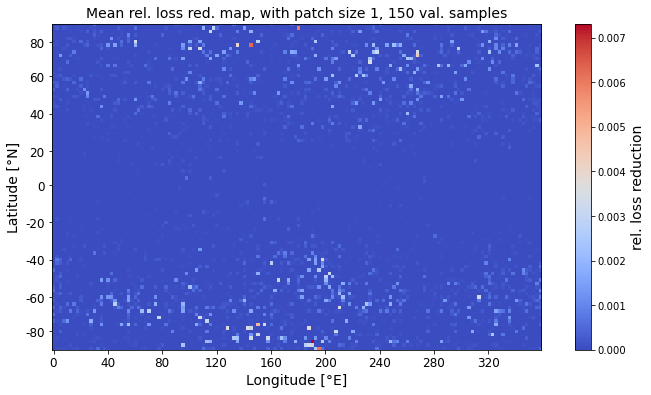

In [27]:
# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [ ]:
#### OLD stuff: Below...

In [120]:
# Define function to compute relevance map for single sample:
def compute_single_relevance_map(input_sample, patch_size, model, max_patch_num, max_acc_rel_loss_reduction):
    """Compute relevance map for single sample, divided into squared patches, from given model.

    Parameters
    ----------
    input_sample: numpy.ndarray
        Single input sample, dimension (1, latitude, longitude, 1), where the last dimension specifies the number of channels, here: 1.
    patch_size: int
        Size of edges of squared patches, that the sample will divided to.
    model: tensorflow.model
        Pre-trained model to get predictions from.
    max_patch_num: int
        Stop adding patches after reaching this specified number of maximum patches to include.
        If set to -1, include ALL patches.
    max_acc_rel_loss_reduction: float
        Or stop adding patches after accumulated rel. loss reduction exceeds this specified threshold.
        
    Returns
    -------
    numpy.ndarray
        Heat map of relative loss reduction of each patch, when added. Total relative loss sums up to one, if include all patches. 
        Dimensions equal original input sample's latitude and longitude.
    
    numpy.ndarrays patch_order, abs_loss_reduction, rel_loss_reduction, acc_rel_loss_reduction
        Patch numbers ordered by decreasing relevance, absolute and relative loss reduction, and accumulated rel. loss reduction

    """
    
    ## Get parameters for patches, enumerated line-by-line, from left to right, from top to bottom, starting with ZERO.

    # Get number of patches in lat and lon directions, respectively:
    n_lat = int(input_sample.shape[1] / patch_size)
    n_lon = int(input_sample.shape[2] / patch_size)

    # Obtain total number of patches:
    n_patches = int(n_lat * n_lon)
    
    # Check for maximum number of desired patches: If given as -1, set to total number of patches.
    if max_patch_num == -1:
        max_patch_num = n_patches

    # Create list of patch indices:
    patch_indices = list(np.arange(n_patches))
    
    # Create empty sample of just ZEROs:
    empty_sample = np.zeros((1, input_sample.shape[1], input_sample.shape[2]))
    
    # Get mean state on empty sample as input:
    mean_state = model.predict(empty_sample)
    
    # Get prediction from complete sample as input:
    full_pred = model.predict(input_sample)
    
    # Compute mean state loss from prediction on empty sample compared to target (= complete input sample):
    mean_state_loss = np.mean((mean_state[:,:,:,0] - input_sample[0,:,:,0])**2)
    
    # Compute min loss from prediction on complete sample compared to target (= complete input sample):
    min_loss = np.mean((full_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

    ## Process patches, one-by-one, to save memory:

    # Initialize storage for patchy loss:
    patchy_loss_all = []
    
    # Run over list of patch indices:
    for n in range(len(patch_indices)):

        # Initialize storage for current patch as boolean array. Dimension (1, latitude, longitude)
        patch = (np.zeros((1, input_sample.shape[1], input_sample.shape[2])) != 0)

        # Get current patch index:
        patch_index = patch_indices[n]

        # Get x and y coordinate from current patch index:
        y = patch_index // n_lon
        x = patch_index % n_lon    

        # Create mask for current patch:
        patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 
    
        # Expand dimensions of patch: Have last dimension for channel (=1), to match requirements for CNN inputs.
        patch_extended = np.expand_dims(patch, axis=-1)

        # Create input applying patch to given input sample:
        patchy_input = patch_extended * input_sample

        # Get model predictions on patchy input:
        patchy_pred = model.predict(patchy_input)
 
        # Compute loss of patchy prediction compared to target (= complete input sample):
        patchy_loss = np.mean((patchy_pred[:,:,:,0] - input_sample[0,:,:,0])**2,axis=(1,2))

        # Store patchy loss for current patch:
        patchy_loss_all.append(patchy_loss[0])
        
    # Convert list containing patchy loss for all patches into numpy array:
    patchy_loss_all = np.array(patchy_loss_all)    
    
    # Initialize storage for patches ordered by decreasing relevance, absolute and relative loss reduction, 
    # and accumulated rel. loss reduction:
    patch_order = []
    abs_loss_reduction = []
    rel_loss_reduction = []
    acc_rel_loss_reduction = []

    # get index for patch leading to lowest loss, when adding:
    min_index = np.argsort(patchy_loss_all)[0]

    # Save index of first patch, leading to lowest loss:
    patch_order.append(patch_indices[min_index])

    # Save absolute loss reduction, when adding this patch:
    abs_loss_reduction.append(mean_state_loss - patchy_loss_all[min_index])

    # Save loss reduction relative to the difference of mean state loss and min. loss, when adding this patch:
    rel_loss_reduction.append((mean_state_loss - patchy_loss_all[min_index]) / (mean_state_loss - min_loss))
    
    # Save accumulated rel. loss reduction, for first patch it equals the usual rel. loss reduction:
    acc_rel_loss_reduction.append(rel_loss_reduction[0])

    ## Fix the previously identified patch with lowest reconstruction loss, as new base patch.
    ## Therefore rebuild corresponding batch from found min_index:
    
    # Initialize storage for new base patch as boolean array. Dimension (1, latitude, longitude)
    base_patch = (np.zeros((1, input_sample.shape[1], input_sample.shape[2])) != 0)
    
    # Get x and y coordinate for patch that corresponds to min_index:
    y = patch_indices[min_index] // n_lon
    x = patch_indices[min_index] % n_lon    

    # Create mask for base patch:
    base_patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 
    
    # Create base input from base patch and given input sample:
    base_input = (np.expand_dims(base_patch, axis=-1) * input_sample)

    # Get model prediction on base input:
    base_pred = model.predict(base_input)
    
    # Compute loss from prediction on base sample compared to target (= complete input sample):
    base_loss = np.mean((base_pred[:,:,:,0] - input_sample[0,:,:,0])**2)
            
    ## Run over the remaining patches, check, if stopping criterions are fulfilled:
    for i in range(n_patches-1):

        # Check for maximum number of patches to include and threshold for accumulated rel. loss reduction:
        if (len(patch_order) >= max_patch_num) | (acc_rel_loss_reduction[-1] >= max_acc_rel_loss_reduction):
            break
        else:        
            ## Create new patches:

            # Remove previously selected patch from list of patch indices:
            patch_indices.remove(patch_indices[min_index])

            ## Process remaining patches, one-by-one, to save memory:

            # Initialize storage for patchy loss:
            patchy_loss_all = []
            
            # Run over list of remaining patch indices:
            for n in range(len(patch_indices)):            
            
                # Initialize storage for current patch by copying former base patch.
                # Dimensions: (1, latitude, longitude)
                patch = np.copy(base_patch)

                # Get current patch index:
                patch_index = patch_indices[n]

                # Get x and y coordinate from current patch index:
                y = patch_index // n_lon
                x = patch_index % n_lon    

                # Store mask for current patch:
                patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

                # Expand dimensions of patch: Have last dimension for channel (=1), to match requirements for CNN inputs.
                patch_extended = np.expand_dims(patch, axis=-1)

                # Create input sample from current patch and given input sample:
                patchy_input = patch_extended * input_sample

                # Get model prediction on patchy inputs:
                patchy_pred = model.predict(patchy_input)

                # Compute loss (mean squared error) of patchy prediction compared to target (= complete input sample):
                patchy_loss = np.mean((patchy_pred[:,:,:,0] - input_sample[0,:,:,0])**2,axis=(1,2))

                # Store patchy loss for current patch:
                patchy_loss_all.append(patchy_loss[0])
        
            # Convert list containing patchy loss for all remaining patches into numpy array:
            patchy_loss_all = np.array(patchy_loss_all)   
            
            # get index for patch leading to lowest loss, when adding:
            min_index = np.argsort(patchy_loss_all)[0]

            # Save index of first patch, leading to lowest loss:
            patch_order.append(patch_indices[min_index])

            # Save absolute loss reduction, when adding this patch:
            abs_loss_reduction.append(base_loss - patchy_loss_all[min_index])

            # Save loss reduction relative to the difference of mean state loss and min. loss, when adding this patch:
            rel_loss_reduction.append((base_loss - patchy_loss_all[min_index]) / (mean_state_loss - min_loss))
            
            # Save accumulated rel. loss reduction:
            acc_rel_loss_reduction.append(acc_rel_loss_reduction[-1]+rel_loss_reduction[-1])
            
            ## Fix the previously identified patch with lowest reconstruction loss, as new base patch.
            ## Therefore rebuild corresponding batch from found min_index:
            
            # Get x and y coordinate for patch index that corresponds to min_index:
            y = patch_indices[min_index] // n_lon
            x = patch_indices[min_index] % n_lon    

            # Create mask for base patch:
            base_patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

            # Create base input from base patch and given input sample:
            base_input = (np.expand_dims(base_patch, axis=-1) * input_sample)

            # Get model prediction on base input:
            base_pred = model.predict(base_input)

            # Compute loss from prediction on base sample compared to target (= complete input sample):
            base_loss = np.mean((base_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

    
    ## Post-processing of patch order, in combination with rel. loss reduction.
    ## Aim to have a heat map with original size from input samples in latitude and longitude.
    ## Grid points for each patch get rel. loss reduction of individual patch as constant value.

    # Initialize storage:
    rel_loss_reduction_map = np.zeros((input_sample.shape[1], input_sample.shape[2]))

    # Run over list containing patch order:
    for n in range(len(patch_order)):

        # Get current patch index:
        patch_index = patch_order[n]

        # Get x and y coordinate from current patch index:
        y = patch_index // n_lon
        x = patch_index % n_lon    

        # Store rel. loss reduction for current patch:
        rel_loss_reduction_map[int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = rel_loss_reduction[n] 

    ## Convert lists to np.arrays of unified maximum length (n_patches), for convenient post-processing:
    
    # Initialize storages, want to recognize unfilled entries as NaN, to avoid misunderstanding:
    patch_order_array = np.zeros(n_patches)+float('nan')
    abs_loss_reduction_array = np.zeros(n_patches)+float('nan')
    rel_loss_reduction_array = np.zeros(n_patches)+float('nan')
    acc_rel_loss_reduction_array = np.zeros(n_patches)+float('nan')
    
    # Fill lists' content into arrays:
    patch_order_array[:len(patch_order)]=patch_order
    abs_loss_reduction_array[:len(patch_order)]=abs_loss_reduction
    rel_loss_reduction_array[:len(patch_order)]=rel_loss_reduction
    acc_rel_loss_reduction_array[:len(patch_order)]=acc_rel_loss_reduction
            
    return rel_loss_reduction_map, patch_order_array, abs_loss_reduction_array, rel_loss_reduction_array, acc_rel_loss_reduction_array

In [70]:
patch_size = 48
input_sample=val_input[0:1]
max_patch_num=6,
max_acc_rel_loss_reduction=1.0

min_index: 4


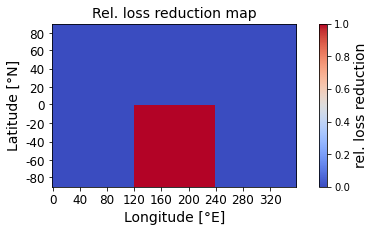

base_loss: 0.0014851639


In [113]:
## Get parameters for patches, enumerated line-by-line, from left to right, from top to bottom, starting with ZERO.

# Get number of patches in lat and lon directions, respectively:
n_lat = int(input_sample.shape[1] / patch_size)
n_lon = int(input_sample.shape[2] / patch_size)

# Obtain total number of patches:
n_patches = int(n_lat * n_lon)

# Check for maximum number of desired patches: If given as -1, set to total number of patches.
if max_patch_num == -1:
    max_patch_num = n_patches

# Create list of patch indices:
patch_indices = list(np.arange(n_patches))

# Create empty sample of just ZEROs:
empty_sample = np.zeros((1, input_sample.shape[1], input_sample.shape[2]))

# Get mean state on empty sample as input:
mean_state = model.predict(empty_sample)

# Get prediction from complete sample as input:
full_pred = model.predict(input_sample)

# Compute mean state loss from prediction on empty sample compared to target (= complete input sample):
mean_state_loss = np.mean((mean_state[:,:,:,0] - input_sample[0,:,:,0])**2)

# Compute min loss from prediction on complete sample compared to target (= complete input sample):
min_loss = np.mean((full_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

## Process patches, one-by-one, to save memory:

# Initialize storage for patchy loss:
patchy_loss_all = []

# Run over list of patch indices:
for n in range(len(patch_indices)):

    # Initialize storage for current patch as boolean array. Dimension (1, latitude, longitude)
    patch = (np.zeros((1, input_sample.shape[1], input_sample.shape[2])) != 0)

    # Get current patch index:
    patch_index = patch_indices[n]

    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    

    # Create mask for current patch:
    patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

    # Expand dimensions of patch: Have last dimension for channel (=1), to match requirements for CNN inputs.
    patch_extended = np.expand_dims(patch, axis=-1)

    # Create input applying patch to given input sample:
    patchy_input = patch_extended * input_sample

    # Get model predictions on patchy input:
    patchy_pred = model.predict(patchy_input)

    # Compute loss of patchy prediction compared to target (= complete input sample):
    patchy_loss = np.mean((patchy_pred[:,:,:,0] - input_sample[0,:,:,0])**2,axis=(1,2))

    # Store patchy loss for current patch:
    patchy_loss_all.append(patchy_loss[0])

# Convert list containing patchy loss for all patches into numpy array:
patchy_loss_all = np.array(patchy_loss_all)    

# Initialize storage for patches ordered by decreasing relevance, absolute and relative loss reduction, 
# and accumulated rel. loss reduction:
patch_order = []
abs_loss_reduction = []
rel_loss_reduction = []
acc_rel_loss_reduction = []

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss_all)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(mean_state_loss - patchy_loss_all[min_index])

# Save loss reduction relative to the difference of mean state loss and min. loss, when adding this patch:
rel_loss_reduction.append((mean_state_loss - patchy_loss_all[min_index]) / (mean_state_loss - min_loss))

# Save accumulated rel. loss reduction, for first patch it equals the usual rel. loss reduction:
acc_rel_loss_reduction.append(rel_loss_reduction[0])

## Fix the previously identified patch with lowest reconstruction loss, as new base patch.
## Therefore rebuild corresponding batch from found min_index:

# Initialize storage for new base patch as boolean array. Dimension (1, latitude, longitude)
base_patch = (np.zeros((1, input_sample.shape[1], input_sample.shape[2])) != 0)

# Get x and y coordinate from min_index:
y = min_index // n_lon
x = min_index % n_lon    

# Create mask for base patch:
base_patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

print("min_index:",min_index)
# Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(base_patch[0,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Rel. loss reduction map', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()


# Create base input from base patch and given input sample:
base_input = (np.expand_dims(base_patch, axis=-1) * input_sample)

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Compute loss from prediction on base sample compared to target (= complete input sample):
base_loss = np.mean((base_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

print("base_loss:", base_loss)

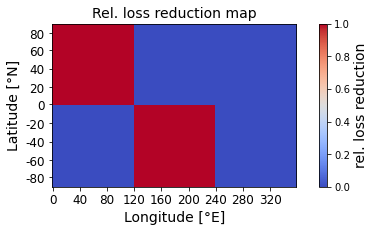

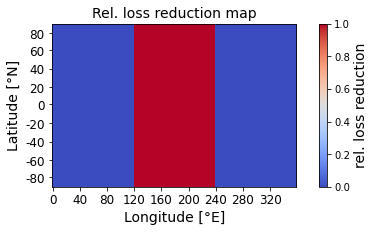

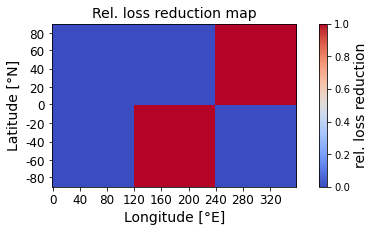

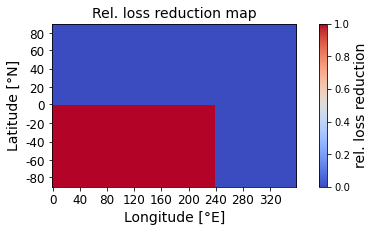

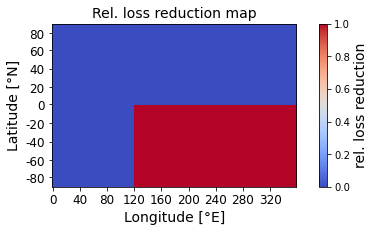

min_index: 3


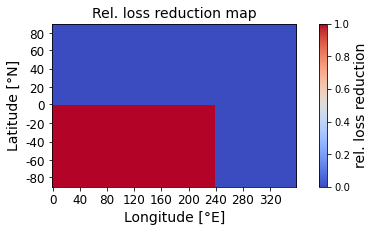

base_loss: 0.00083956274


In [114]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])

## Process remaining patches, one-by-one, to save memory:

# Initialize storage for patchy loss:
patchy_loss_all = []

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):            

    # Initialize storage for current patch by copying former base patch.
    # Dimensions: (1, latitude, longitude)
    patch = np.copy(base_patch)

    # Get current patch index:
    patch_index = patch_indices[n]

    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    

    # Store mask for current patch:
    patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

    # Expand dimensions of patch: Have last dimension for channel (=1), to match requirements for CNN inputs.
    patch_extended = np.expand_dims(patch, axis=-1)

    # Create input sample from current patch and given input sample:
    patchy_input = patch_extended * input_sample

    # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(patch[0,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('rel. loss reduction', fontsize=14)
    plt.title('Rel. loss reduction map', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Get model prediction on patchy inputs:
    patchy_pred = model.predict(patchy_input)

    # Compute loss (mean squared error) of patchy prediction compared to target (= complete input sample):
    patchy_loss = np.mean((patchy_pred[:,:,:,0] - input_sample[0,:,:,0])**2,axis=(1,2))

    # Store patchy loss for current patch:
    patchy_loss_all.append(patchy_loss[0])

# Convert list containing patchy loss for all remaining patches into numpy array:
patchy_loss_all = np.array(patchy_loss_all)   

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss_all)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss_all[min_index])

# Save loss reduction relative to the difference of mean state loss and min. loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss_all[min_index]) / (mean_state_loss - min_loss))

# Save accumulated rel. loss reduction:
acc_rel_loss_reduction.append(acc_rel_loss_reduction[-1]+rel_loss_reduction[-1])

## Fix the previously identified patch with lowest reconstruction loss, as new base patch.
## Therefore rebuild corresponding batch from found min_index:

# Get x and y coordinate from min_index:
y = min_index // n_lon
x = min_index % n_lon    

# Create mask for base patch:
base_patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

print("min_index:",min_index)
# Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(base_patch[0,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Rel. loss reduction map', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create base input from base patch and given input sample:
base_input = (np.expand_dims(base_patch, axis=-1) * input_sample)

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Compute loss from prediction on base sample compared to target (= complete input sample):
base_loss = np.mean((base_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

print("base_loss:", base_loss)

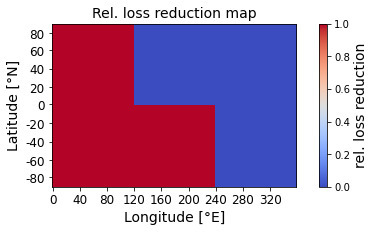

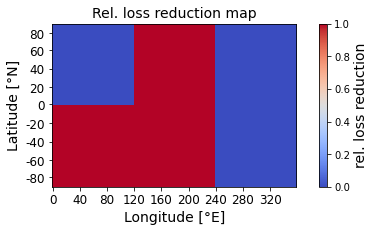

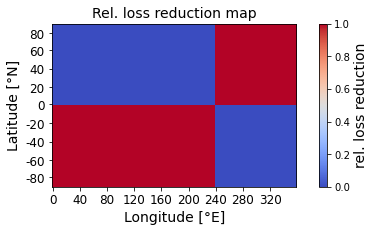

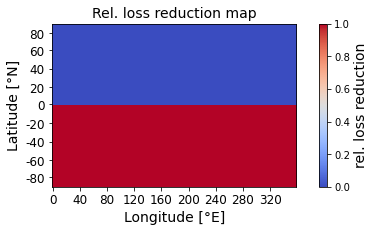

min_index: 3


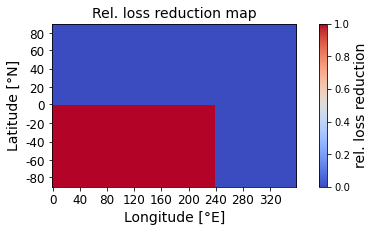

base_loss: 0.00083956274


In [115]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])

## Process remaining patches, one-by-one, to save memory:

# Initialize storage for patchy loss:
patchy_loss_all = []

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):            

    # Initialize storage for current patch by copying former base patch.
    # Dimensions: (1, latitude, longitude)
    patch = np.copy(base_patch)

    # Get current patch index:
    patch_index = patch_indices[n]

    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    

    # Store mask for current patch:
    patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

    # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(patch[0,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('rel. loss reduction', fontsize=14)
    plt.title('Rel. loss reduction map', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()
    
    # Expand dimensions of patch: Have last dimension for channel (=1), to match requirements for CNN inputs.
    patch_extended = np.expand_dims(patch, axis=-1)

    # Create input sample from current patch and given input sample:
    patchy_input = patch_extended * input_sample

    # Get model prediction on patchy inputs:
    patchy_pred = model.predict(patchy_input)

    # Compute loss (mean squared error) of patchy prediction compared to target (= complete input sample):
    patchy_loss = np.mean((patchy_pred[:,:,:,0] - input_sample[0,:,:,0])**2,axis=(1,2))

    # Store patchy loss for current patch:
    patchy_loss_all.append(patchy_loss[0])

# Convert list containing patchy loss for all remaining patches into numpy array:
patchy_loss_all = np.array(patchy_loss_all)   

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss_all)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss_all[min_index])

# Save loss reduction relative to the difference of mean state loss and min. loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss_all[min_index]) / (mean_state_loss - min_loss))

# Save accumulated rel. loss reduction:
acc_rel_loss_reduction.append(acc_rel_loss_reduction[-1]+rel_loss_reduction[-1])

## Fix the previously identified patch with lowest reconstruction loss, as new base patch.
## Therefore rebuild corresponding batch from found min_index:

# Get x and y coordinate from min_index:
y = min_index // n_lon
x = min_index % n_lon    

# Create mask for base patch:
base_patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

print("min_index:",min_index)
# Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(base_patch[0,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Rel. loss reduction map', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create base input from base patch and given input sample:
base_input = (np.expand_dims(base_patch, axis=-1) * input_sample)

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Compute loss from prediction on base sample compared to target (= complete input sample):
base_loss = np.mean((base_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

print("base_loss:", base_loss)

In [118]:
patch_indices

[0, 1, 2, 5]

In [117]:
np.argsort(patchy_loss_all)

array([3, 2, 1, 0])

In [119]:
patch_order

[4, 3, 5]

min_index: 2


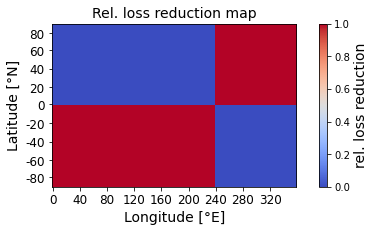

base_loss: 0.00062822923


In [112]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])

## Process remaining patches, one-by-one, to save memory:

# Initialize storage for patchy loss:
patchy_loss_all = []

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):            

    # Initialize storage for current patch by copying former base patch.
    # Dimensions: (1, latitude, longitude)
    patch = np.copy(base_patch)

    # Get current patch index:
    patch_index = patch_indices[n]

    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    

    # Store mask for current patch:
    patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

    # Expand dimensions of patch: Have last dimension for channel (=1), to match requirements for CNN inputs.
    patch_extended = np.expand_dims(patch, axis=-1)

    # Create input sample from current patch and given input sample:
    patchy_input = patch_extended * input_sample

    # Get model prediction on patchy inputs:
    patchy_pred = model.predict(patchy_input)

    # Compute loss (mean squared error) of patchy prediction compared to target (= complete input sample):
    patchy_loss = np.mean((patchy_pred[:,:,:,0] - input_sample[0,:,:,0])**2,axis=(1,2))

    # Store patchy loss for current patch:
    patchy_loss_all.append(patchy_loss[0])

# Convert list containing patchy loss for all remaining patches into numpy array:
patchy_loss_all = np.array(patchy_loss_all)   

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss_all)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss_all[min_index])

# Save loss reduction relative to the difference of mean state loss and min. loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss_all[min_index]) / (mean_state_loss - min_loss))

# Save accumulated rel. loss reduction:
acc_rel_loss_reduction.append(acc_rel_loss_reduction[-1]+rel_loss_reduction[-1])

## Fix the previously identified patch with lowest reconstruction loss, as new base patch.
## Therefore rebuild corresponding batch from found min_index:

# Get x and y coordinate from min_index:
y = min_index // n_lon
x = min_index % n_lon    

# Create mask for base patch:
base_patch[0,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = True 

print("min_index:",min_index)
# Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(base_patch[0,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Rel. loss reduction map', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create base input from base patch and given input sample:
base_input = (np.expand_dims(base_patch, axis=-1) * input_sample)

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Compute loss from prediction on base sample compared to target (= complete input sample):
base_loss = np.mean((base_pred[:,:,:,0] - input_sample[0,:,:,0])**2)

print("base_loss:", base_loss)

In [3]:
## Reload final model, trained on range:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'range_50_999'
augmentation_factor = 3
run = '_final'

# Get path to stored validation loss from batch:
path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

print(path_to_model)

# Reload parameters for this experiment:
with open(path_to_model / 'parameters.json', 'r') as f:
    parameters=load(f)

train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values']
scale_to = parameters['scale_to']

# Reload final model, trained on range:
model = tf.keras.models.load_model(path_to_model / 'missing_50_999' / 'model')

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final


2023-02-01 04:53:55.432268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-01 04:53:55.432303: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-01 04:53:55.432316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl110): /proc/driver/nvidia/version does not exist
2023-02-01 04:53:55.437110: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
## Load validation samples:

# Path to full data:
path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# Load data:
data = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data)

# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(data.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask_1,
    train_val_split, 
    scale_to
)

In [121]:
# Get natch numbers ordered by decreasing relevance, absolute and relative loss reduction for single validation sample:
patch_size = 48
input_sample=val_input[0:1]

(
    rel_loss_reduction_map, 
    patch_order, 
    abs_loss_reduction, 
    rel_loss_reduction, 
    acc_rel_loss_reduction
) = compute_single_relevance_map(input_sample=input_sample,
                                 patch_size=patch_size, 
                                 model=model,
                                 max_patch_num=6,
                                 max_acc_rel_loss_reduction=1.0
                                )

In [92]:
patch_order

array([4., 3., 5., 2., 1., 0.])

In [93]:
abs_loss_reduction

array([2.25015590e-03, 6.45601191e-04, 2.45324860e-04, 2.26752833e-04,
       9.99306212e-05, 1.85883473e-04])

In [94]:
rel_loss_reduction

array([0.61586541, 0.1767004 , 0.06714517, 0.06206202, 0.02735091,
       0.05087612])

In [95]:
acc_rel_loss_reduction

array([0.61586541, 0.79256582, 0.85971099, 0.92177302, 0.94912392,
       1.        ])

In [122]:
patch_order

array([4., 3., 5., 2., 1., 0.])

In [123]:
abs_loss_reduction

array([2.25015590e-03, 6.45601191e-04, 2.45324860e-04, 2.26752833e-04,
       9.99306212e-05, 1.85883473e-04])

In [124]:
rel_loss_reduction

array([0.61586541, 0.1767004 , 0.06714517, 0.06206202, 0.02735091,
       0.05087612])

In [125]:
acc_rel_loss_reduction

array([0.61586541, 0.79256582, 0.85971099, 0.92177302, 0.94912392,
       1.        ])

In [83]:
np.round(0.003735319578619876-8.167095281900498e-05,6)

0.003654

In [137]:
acc_rel_loss_reduction

array([0.61586536, 0.79256578, 0.85971093, 0.92177297,        nan,
              nan])

In [141]:
patch_order[np.isnan(patch_order)]=0
patch_order

array([4., 3., 5., 2., 0., 0.])

In [139]:
abs_loss_reduction

array([0.00225016, 0.0006456 , 0.00024532, 0.00022675,        nan,
              nan])

In [121]:
sum(abs_loss_reduction)

0.003653648625800871

In [122]:
sum(rel_loss_reduction)

1.0

In [123]:
# Initialize storage for accumulated rel. loss reduction:
acc_rel_loss_reduction = np.zeros(len(rel_loss_reduction)+1)

# Loop over entries in rel. los reduction:
for i in range(len(rel_loss_reduction)):
    
    if i == 0:
        acc_rel_loss_reduction[i+1] = rel_loss_reduction[i]
    else:
        acc_rel_loss_reduction[i+1] = acc_rel_loss_reduction[i] + rel_loss_reduction[i]

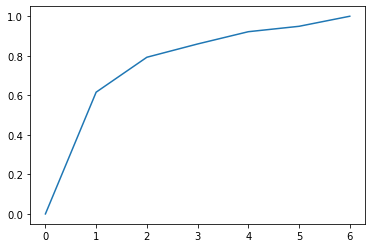

In [124]:
plt.plot(acc_rel_loss_reduction)

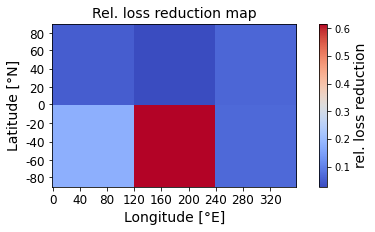

In [125]:
# Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Rel. loss reduction map', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

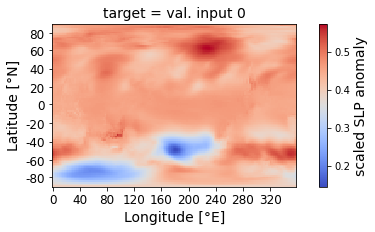

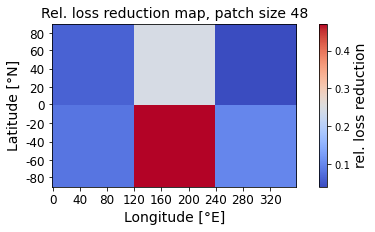

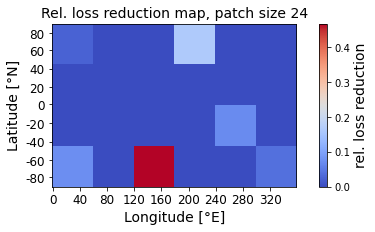

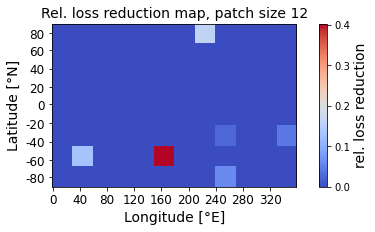

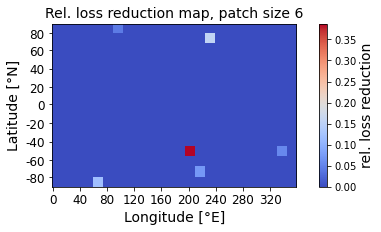

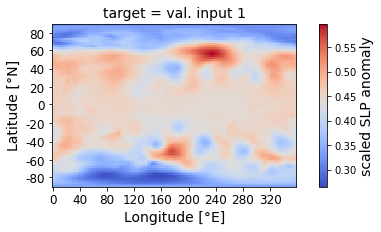

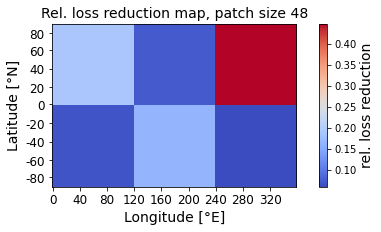

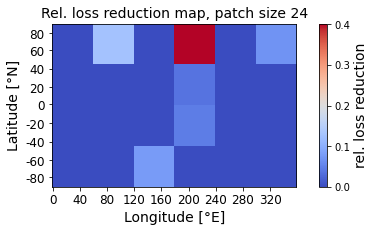

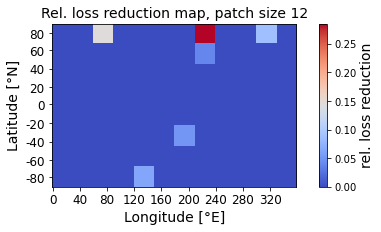

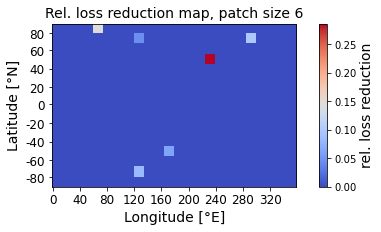

In [8]:
## Batch for first two validation samples and patch_sizes = [48, 24, 12, 6]:

# Define patch sizes:
patch_sizes = [48, 24]

# Define number of validation samples:
n_samples = 2

# Reload obtained rel. loss reduction maps:
rel_loss_reduction_maps = np.load(path_to_model / 'rel_loss_reduction_maps.npy')

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
       
    plt.show()

    # Loop over patch sizes:
    for p in range(len(patch_sizes)):
        
        # Get current patch size:
        patch_size = patch_sizes[p]
   
        # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
        fig, ax = plt.subplots(figsize=(8, 3))
        im = plt.imshow(rel_loss_reduction_maps[n,p,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
        cbar = plt.colorbar(im)
        cbar.set_label('rel. loss reduction', fontsize=14)
        plt.title('Rel. loss reduction map, patch size '+str(patch_size), fontsize=14)
        plt.xlabel('Longitude [°E]', fontsize=14)
        plt.ylabel('Latitude [°N]', fontsize=14)
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
        plt.show()

In [20]:
np.sum(rel_loss_reduction_maps[0,3])/(6**2)

0.8331036528568071

In [21]:
rel_loss_reduction_maps[0,3].shape

(96, 144)

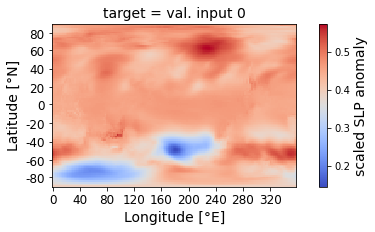

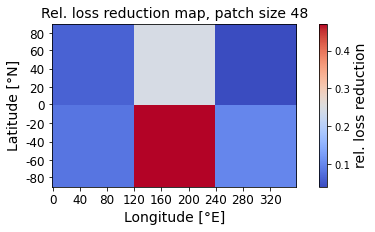

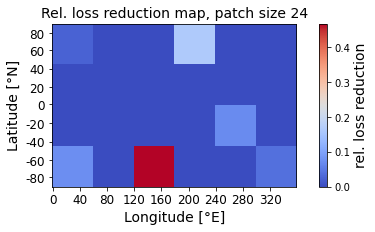

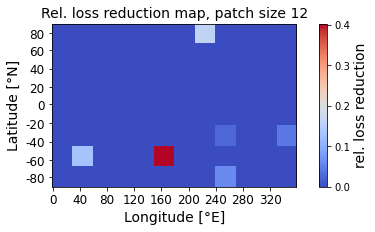

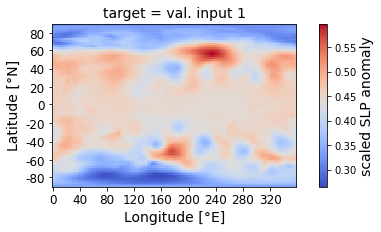

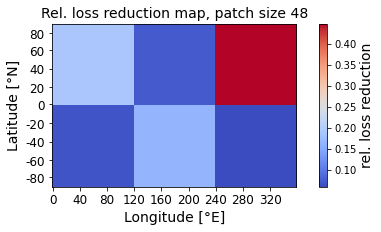

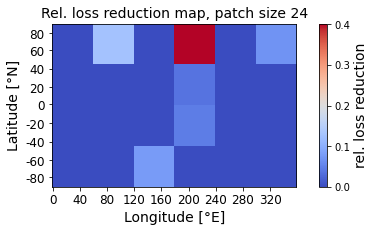

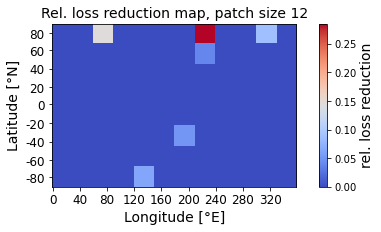

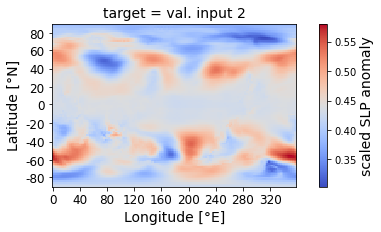

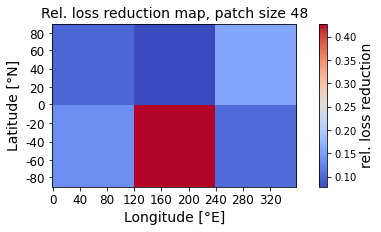

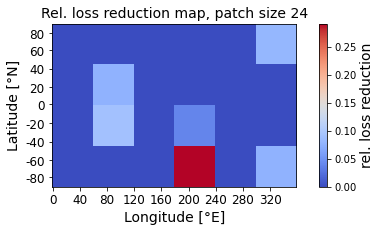

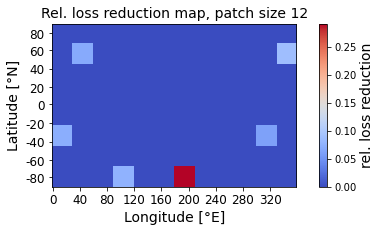

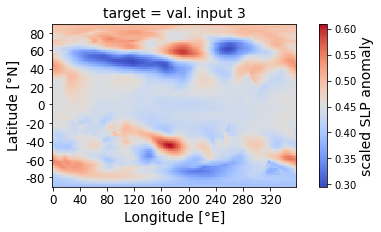

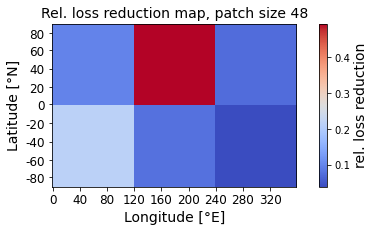

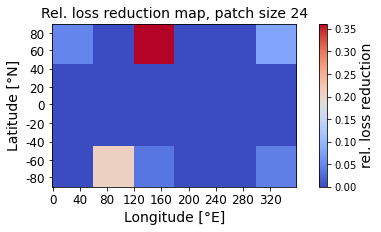

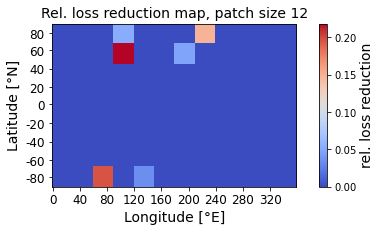

In [24]:
## Show rel. loss reduction maps, serving as relevance maps, for several validation inputs and various patch sizes:

# Define patch sizes:
patch_sizes = [48, 24, 12]

# Define number of validation samples:
n_samples = 4

# Initialize storage for resulting relevance maps, dimension: (#samples, #patch sizes, latitude, longitude)
rel_loss_reduction_maps = np.zeros((n_samples, len(patch_sizes), data.shape[1], data.shape[2]))

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
       
    plt.show()

    # Loop over patch sizes:
    for p in range(len(patch_sizes)):
        
        # Get current patch size:
        patch_size = patch_sizes[p]
        
        # Compute and store relevance map for current sample and chosen patch size:
        rel_loss_reduction_maps[n,p,:,:] = compute_single_relevance_map(input_sample=val_input[n:n+1], patch_size=patch_size, model=model)    
    
        # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
        fig, ax = plt.subplots(figsize=(8, 3))
        im = plt.imshow(rel_loss_reduction_maps[n,p,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
        cbar = plt.colorbar(im)
        cbar.set_label('rel. loss reduction', fontsize=14)
        plt.title('Rel. loss reduction map, patch size '+str(patch_size), fontsize=14)
        plt.xlabel('Longitude [°E]', fontsize=14)
        plt.ylabel('Latitude [°N]', fontsize=14)
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
        plt.show()
    

In [ ]:
##### OLD code for early development: Plot masks, patchy inputs and patchy predictions.

In [321]:
## Pick validation sample:
sample = 0

In [322]:
## Create masks for patches, enumerated line-by-line, from left to right, from top to bottom, starting with ONE.

# Specify patch size:
patch_size = 48

# Get number of patches in lat and lon directions, respectively:
n_lat = int(data.shape[1] / patch_size)
n_lon = int(data.shape[2] / patch_size)

# Obtain number of patches:
n_patches = int(n_lat * n_lon)

# Create list of patch indices:
patch_indices = list(np.arange(n_patches))

In [323]:
# Create empty sample of just ZEROs:
empty_sample = np.zeros((1, data.shape[1], data.shape[2]))

## Create patches:

# Initialize storage for patches. Dimension (# of patches, latitude, longitude)
patches = np.zeros((len(patch_indices), data.shape[1], data.shape[2]))

# Run over list of patch indices:
for n in range(len(patch_indices)):
    
    # Get current patch index:
    patch_index = patch_indices[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
    
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 

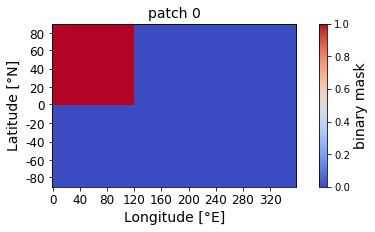

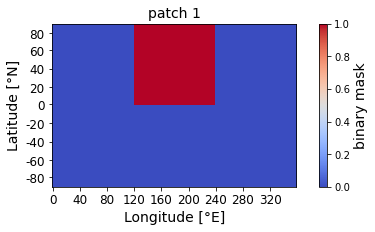

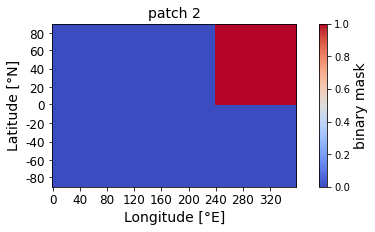

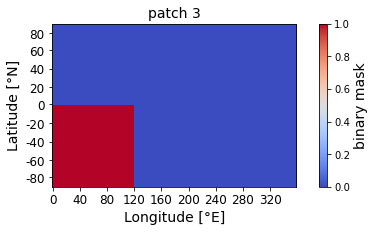

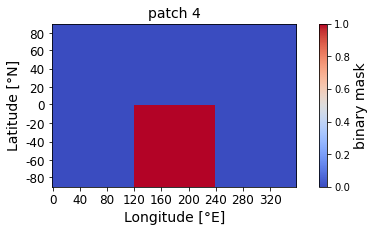

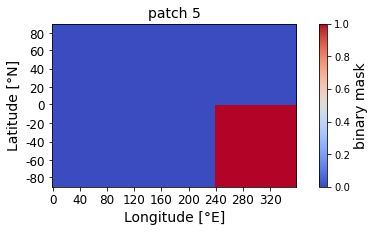

In [324]:
## Plot patches:

for n in range(len(patches)):
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(patches[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("binary mask", fontsize=14)

    plt.title('patch '+str(patch_indices[n]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

In [325]:
# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)
patches_extended.shape

(6, 96, 144, 1)

In [326]:
# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[sample:sample+1]
patchy_input.shape

(6, 96, 144, 1)

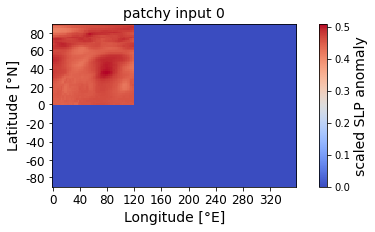

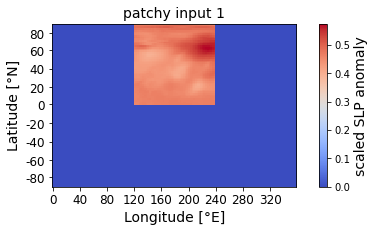

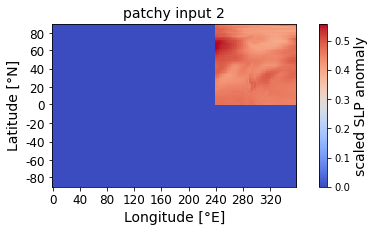

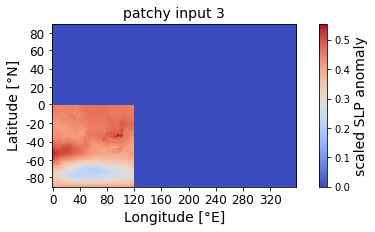

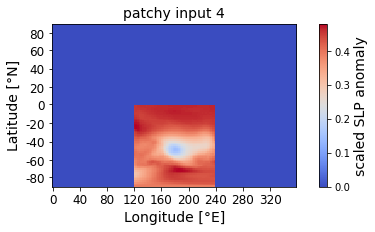

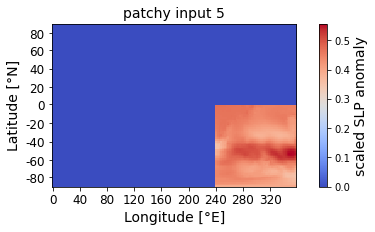

In [327]:
## Plot patchy inputs:

for n in range(len(patchy_input)):
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(patchy_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('patchy input '+str(patch_indices[n]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

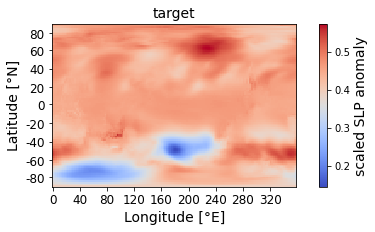

In [328]:
## Plot target:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)

plt.title('target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [329]:
# Get mean state on empty sample as input:
mean_state = model.predict(empty_sample)

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

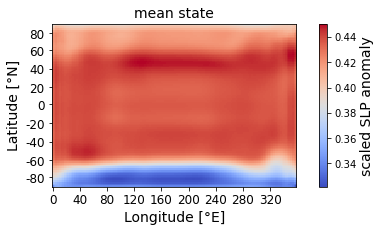

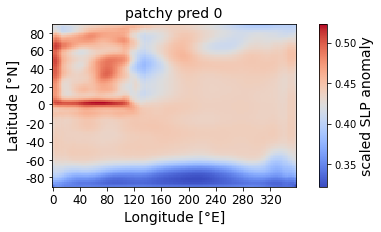

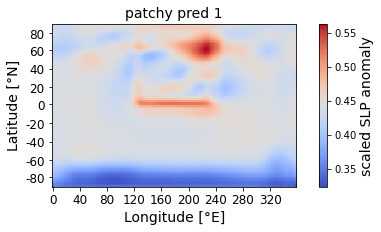

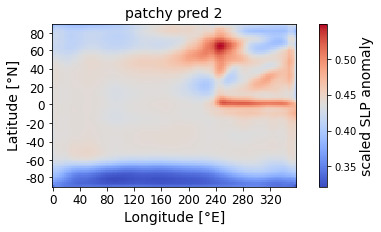

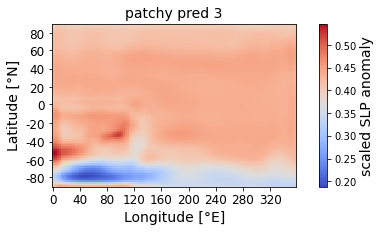

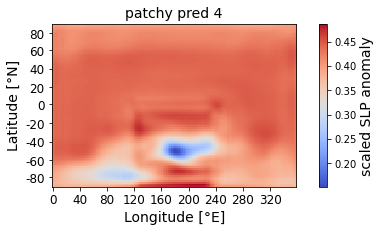

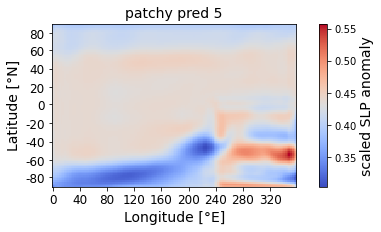

In [330]:
## Plot mean state as prediction on empty sample:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(mean_state[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)

plt.title('mean state', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot model predictions on patchy inputs:

for n in range(len(patchy_pred)):
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(patchy_pred[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('patchy pred '+str(patch_indices[n]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

mean state loss:  0.0029933054


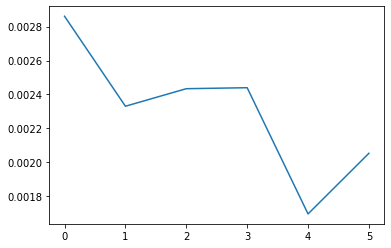

In [331]:
# Compute mean state loss from prediction on empty sample compared to target:
mean_state_loss = np.mean((mean_state[:,:,:,0] - val_target[sample])**2)
print('mean state loss: ', mean_state_loss)

# Compute loss (mean squared error) of patchy predictions compared to targets:
patchy_loss = np.mean((patchy_pred[:,:,:,0] - val_target[sample])**2,axis=(1,2))
plt.plot(patchy_loss)

In [333]:
# Initialize storage for patches ordered by decreasing relevance, absolute and relative loss reduction:
patch_order = []
abs_loss_reduction = []
rel_loss_reduction = []

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(mean_state_loss - patchy_loss[min_index])

# Save loss reduction relative to mean state loss, when adding this patch:
rel_loss_reduction.append((mean_state_loss - patchy_loss[min_index]) / mean_state_loss)

# Fix the previously identified patch with lowest reconstruction loss, as new base patch:
base_patch = patches[min_index]

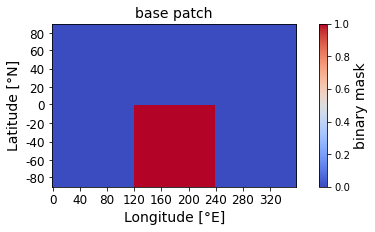

In [334]:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(base_patch, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("binary mask", fontsize=14)

plt.title('base patch', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [335]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])
patch_indices

[0, 1, 2, 3, 5]

In [336]:
# Initialize storage for patches by repeating base patch as often as we have remaining patches.
# Dimensions: (# of remaining patches, latitude, longitude)
patches = np.repeat(np.expand_dims(base_patch,axis=0),len(patch_indices), axis=0)

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):
    
    # Get current patch index:
    patch_index = patch_indices[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
        
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 

In [337]:
# Create base input from base patch:
base_input = (np.expand_dims(base_patch, axis=-1) * val_input[sample:sample+1])

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)

# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[:1]

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

# Compute loss from prediction on base sample compared to target:
base_loss = np.mean((base_pred[:,:,:,0] - val_target[sample])**2)

# Compute loss (mean squared error) of patchy predictions compared to targets:
patchy_loss = np.mean((patchy_pred[:,:,:,0] - val_target[sample])**2,axis=(1,2))

In [338]:
# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss[min_index])

# Save loss reduction relative to mean state loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss[min_index]) / mean_state_loss)

# Fix the previously identified patch with lowest reconstruction loss, as new base patch:
base_patch = patches[min_index]

In [348]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])

# Initialize storage for patches by repeating base patch as often as we have remaining patches.
# Dimensions: (# of remaining patches, latitude, longitude)
patches = np.repeat(np.expand_dims(base_patch,axis=0),len(patch_indices), axis=0)

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):
    
    # Get current patch index:
    patch_index = patch_indices[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
        
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 
    
# Create base input from base patch:
base_input = (np.expand_dims(base_patch, axis=-1) * val_input[sample:sample+1])

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)

# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[:1]

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

# Compute loss from prediction on base sample compared to target:
base_loss = np.mean((base_pred[:,:,:,0] - val_target[sample])**2)

# Compute loss (mean squared error) of patchy predictions compared to targets:
patchy_loss = np.mean((patchy_pred[:,:,:,0] - val_target[sample])**2,axis=(1,2))

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss[min_index])

# Save loss reduction relative to mean state loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss[min_index]) / mean_state_loss)

# Fix the previously identified patch with lowest reconstruction loss, as new base patch:
base_patch = patches[min_index]

In [349]:
print('remaining patch indices: ', patch_indices)
print('patch order: ', patch_order)

remaining patch indices:  [2]
patch order:  [4, 1, 5, 3, 0, 2]


In [350]:
abs_loss_reduction

[0.0012980017,
 0.00067559106,
 0.0002760396,
 0.00022299023,
 0.00017199435,
 0.00010961466]

In [351]:
rel_loss_reduction

[0.4336349, 0.22570068, 0.09221899, 0.074496314, 0.057459675, 0.03661994]

In [357]:
## Post-processing of patch order, in combination with rel. loss reduction.
## Aim to have a heat map with original size from input samples in latitude and longitude.
## Grid points for each patch get rel. loss reduction of individual patch as constant value.

# Initialize storage:
rel_loss_reduction_map = np.zeros((data.shape[1], data.shape[2]))

# Run over list containing patch order:
for n in range(len(patch_order)):
  
    # Get current patch index:
    patch_index = patch_order[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
    
    # Store rel. loss reduction for current patch:
    rel_loss_reduction_map[int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = rel_loss_reduction[n] 
    


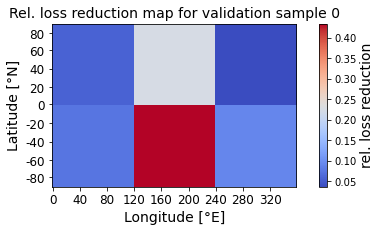

In [366]:
# Plot rel. loss reduction map as heatmap:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("rel. loss reduction", fontsize=14)

plt.title('Rel. loss reduction map for validation sample '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()